In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import shap
from google.cloud import bigquery


# pip install google-cloud-bigquery
# pip install db-dtypes
# pip install google-cloud-bigquery-storage

In [2]:
# Set your project ID
project_id = "is3107-project-457501"

# Create BigQuery client
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "is3107-project-457501-4f502924c0f9.json"
client = bigquery.Client(project=project_id)

# Define your query
query = """
    SELECT * FROM `is3107-project-457501.is3107_dataset.hdb_integrated_data`
"""

# Run the query and convert result to a DataFrame
hdb = client.query(query).to_dataframe()
hdb.drop(columns=['town','flat_type', 'flat_model'], inplace=True)

In [3]:
hdb.head()

,month,floor_area_sqm,lease_commence_date,resale_price,years_from_lease,remaining_lease_months,year,latitude,longitude,average_close,...,storey_mean,is_high_floor,is_big_unit,school_quality,region_East Region,region_North Region,region_North-East Region,region_Rest of Central Region,region_West Region,town_sales_freq
0,1,44.0,1979,232000.0,46,736.0,2017,1.362005,103.85388,3002.991504,...,11.0,0,0,20.6,False,False,False,True,False,8412
1,5,44.0,1979,235000.0,46,732.0,2017,1.362005,103.85388,3229.841448,...,11.0,0,0,20.6,False,False,False,True,False,8412
2,3,44.0,1979,202000.0,46,722.0,2018,1.362005,103.85388,3481.025228,...,2.0,0,0,20.6,False,False,False,True,False,8412
3,3,44.0,1979,210000.0,46,722.0,2018,1.362005,103.85388,3481.025228,...,2.0,0,0,20.6,False,False,False,True,False,8412
4,5,44.0,1979,220000.0,46,720.0,2018,1.362005,103.85388,3532.899030,...,8.0,0,0,20.6,False,False,False,True,False,8412


In [4]:
#Linear Regression 

In [5]:
from sklearn.model_selection import train_test_split

X = hdb.drop(columns=['resale_price'])
y = hdb['resale_price']

# Step 1: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 2: Split remaining 80% into 60% train, 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 of 80% = 20%
)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Combine train and validation sets
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

# Initialize and fit Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_final_train, y_final_train)

# Align test set columns
X_test = X_test.reindex(columns=X_final_train.columns, fill_value=0)

# Predict on test set
test_predictions = linear_model.predict(X_test)

# Evaluate
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

# Print results
print(f'Test R²: {test_r2:.4f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAE: {test_mae:.2f}')


Test R²: 0.8829
Test RMSE: 62314.10
Test MAE: 47420.61


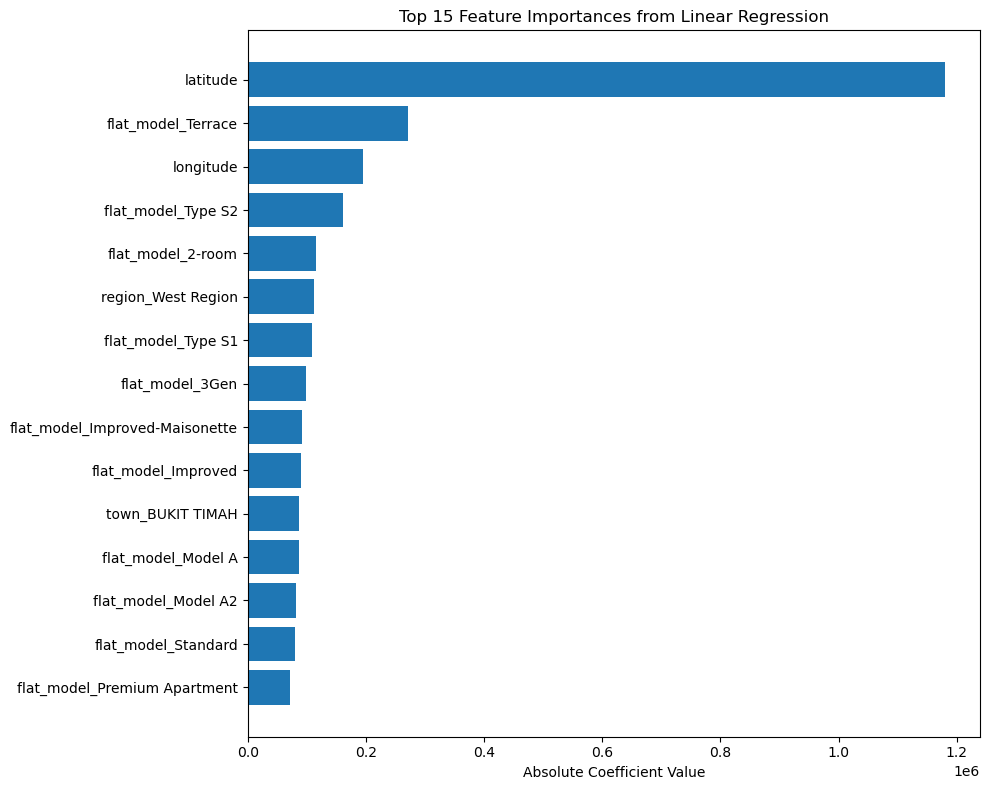

In [7]:
# Get coefficients
coefficients = linear_model.coef_

# Create DataFrame with absolute coefficient values
features_df_lr = pd.DataFrame({
    'Feature': X_final_train.columns,
    'Importance': np.abs(coefficients)  # take abs for comparison like RF
}).sort_values(by='Importance', ascending=False)

# Plot the top 15 features (styled like Random Forest plot)
plt.figure(figsize=(10, 8))
plt.barh(features_df_lr['Feature'].iloc[:15], features_df_lr['Importance'].iloc[:15])
plt.xlabel('Absolute Coefficient Value')
plt.title('Top 15 Feature Importances from Linear Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [8]:
X_test = X_test.reindex(columns=X_final_train.columns, fill_value=0)

# Predict resale prices
test_predictions = linear_model.predict(X_test)

# Evaluate performance
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

# Print metrics
print(f'Test R²: {test_r2:.4f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAE: {test_mae:.2f}')


Test R²: 0.8829
Test RMSE: 62314.10
Test MAE: 47420.61


In [9]:
#Random Forest

In [10]:
#split data
# Separate features and target
X = hdb.drop(columns=['resale_price'])
y = hdb['resale_price']

# Step 1: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 2: Split remaining 80% into 60% train, 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 of 80% = 20%
)


In [11]:
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [10, 20, 30],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'max_features': ['sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# # Define the model
# rf_model = RandomForestRegressor(random_state=42)

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf_model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',  # RMSE (negated, as higher is better in GridSearchCV)
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the search
# grid_search.fit(X_train, y_train)

# # Get the best model
# best_rf_model = grid_search.best_estimator_
# print("Best parameters found:", grid_search.best_params_)

In [12]:
best_params = {
    'n_estimators': 150,
    'max_depth': 30,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',   
    'bootstrap': False,       
    'random_state': 42
}

# Initialize model with best parameters
best_rf_model = RandomForestRegressor(**best_params)

# Fit model on training data
best_rf_model.fit(X_train, y_train)

# Predict on training set
train_predictions = best_rf_model.predict(X_train)

# Evaluate
train_r2 = r2_score(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)

print(f'Training R²: {train_r2:.4f}')
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAE: {train_mae:.2f}')


Training R²: 0.9998
Training RMSE: 2257.91
Training MAE: 779.85


In [13]:
# Predict on validation set
val_predictions = best_rf_model.predict(X_val)

# Evaluate using regression metrics
val_r2 = r2_score(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_mae = mean_absolute_error(y_val, val_predictions)

print(f'Validation R²: {val_r2:.4f}')
print(f'Validation RMSE: {val_rmse:.2f}')
print(f'Validation MAE: {val_mae:.2f}')


Validation R²: 0.9726
Validation RMSE: 29909.64
Validation MAE: 21218.05


In [14]:
# Combine training and validation sets
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

# Initialize a new Random Forest Regressor with best parameters
final_rf_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

# Train the model on combined data
final_rf_model.fit(X_final_train, y_final_train);

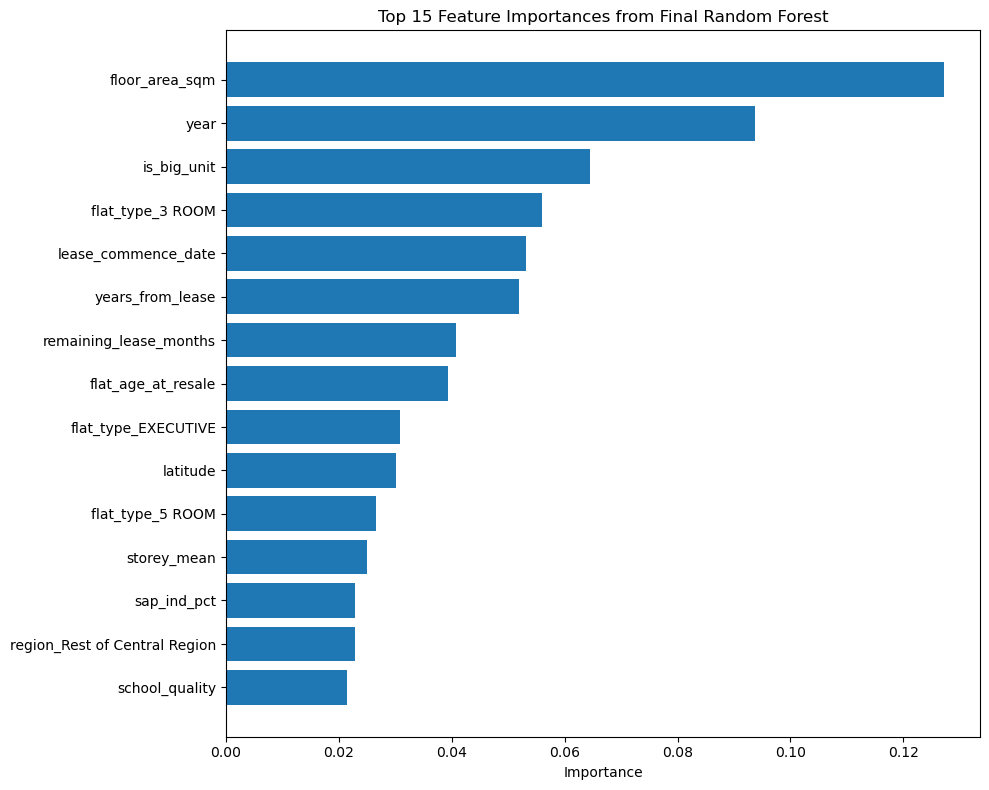

In [15]:
# Feature importance analysis after full retraining
feature_importances = final_rf_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_final_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'].iloc[:15], features_df['Importance'].iloc[:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances from Final Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
     

In [16]:
X_test = X_test.reindex(columns=X_final_train.columns, fill_value=0)

test_predictions = final_rf_model.predict(X_test)
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f'Test R²: {test_r2:.4f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAE: {test_mae:.2f}')

Test R²: 0.9747
Test RMSE: 28977.73
Test MAE: 20471.65


In [17]:
#XGBoost

In [18]:
# Split the data
X = hdb.drop(columns=['resale_price'])
y = hdb['resale_price']

# 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [19]:
# # Define the base model
# xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# # Define a parameter grid (keep it small for speed — expand later if needed)
# param_grid = {
#     'n_estimators': [180, 200, 220],
#     'max_depth': [7, 8, 9],
#     'learning_rate': [0.075, 0.1],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'min_child_weight': [1, 2]
# }

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=xgb_model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',  # minimizes RMSE
#     cv=3,
#     verbose=1,
#     n_jobs=-1
# )

# # Fit the grid search
# grid_search.fit(X_train, y_train)

# # Get the best model and parameters
# best_xgb_model = grid_search.best_estimator_
# print("Best parameters found:", grid_search.best_params_)

In [20]:
best_params = {
    'n_estimators': 220,
    'max_depth': 9,
    'learning_rate': 0.1,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'min_child_weight': 2,
    'random_state': 42
}

best_xgb_model = XGBRegressor(objective='reg:squarederror', **best_params)
best_xgb_model.fit(X_train, y_train)

# 4. Evaluate on training set
train_predictions = best_xgb_model.predict(X_train)
train_r2 = r2_score(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)

print(f'Training R²: {train_r2:.4f}')
print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAE: {train_mae:.2f}')

Training R²: 0.9870
Training RMSE: 20477.97
Training MAE: 15183.21


In [21]:
# 5. Evaluate on validation set
val_predictions = best_xgb_model.predict(X_val)
val_r2 = r2_score(y_val, val_predictions)
val_rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
val_mae = mean_absolute_error(y_val, val_predictions)

print(f'Validation R²: {val_r2:.4f}')
print(f'Validation RMSE: {val_rmse:.2f}')
print(f'Validation MAE: {val_mae:.2f}')

Validation R²: 0.9786
Validation RMSE: 26433.03
Validation MAE: 18921.87


In [22]:
# 7. Retrain on full training data before testing
X_final_train = pd.concat([X_train, X_val])
y_final_train = pd.concat([y_train, y_val])

final_xgb_model = XGBRegressor(objective='reg:squarederror', **best_params)
final_xgb_model.fit(X_final_train, y_final_train);

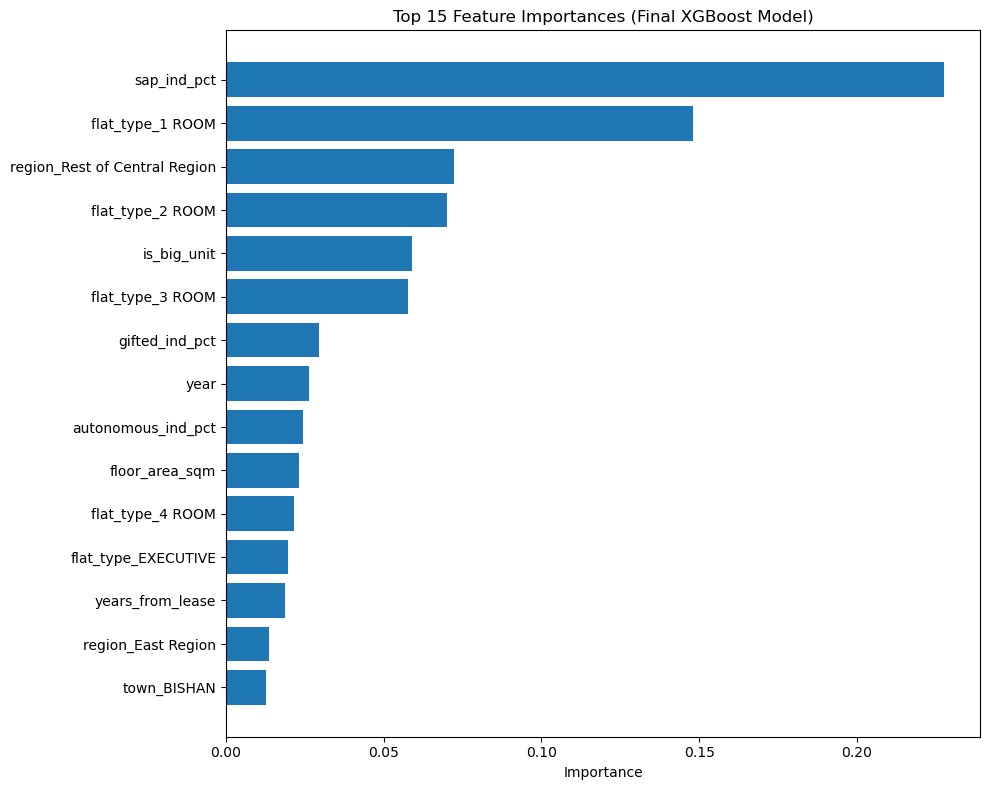

In [23]:
# Retrain on full training data before testing
final_xgb_model = XGBRegressor(objective='reg:squarederror', **best_params)
final_xgb_model.fit(X_final_train, y_final_train)

# Feature importance from final model
feature_importances = final_xgb_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_final_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
plt.barh(features_df['Feature'].iloc[:15], features_df['Importance'].iloc[:15])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Final XGBoost Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [24]:
# Predict and evaluate on test set
test_predictions = final_xgb_model.predict(X_test)
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mae = mean_absolute_error(y_test, test_predictions)

print(f'Test R²: {test_r2:.4f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAE: {test_mae:.2f}')


Test R²: 0.9792
Test RMSE: 26256.87
Test MAE: 18656.89


100%|===================| 163827/163838 [42:12<00:00]        

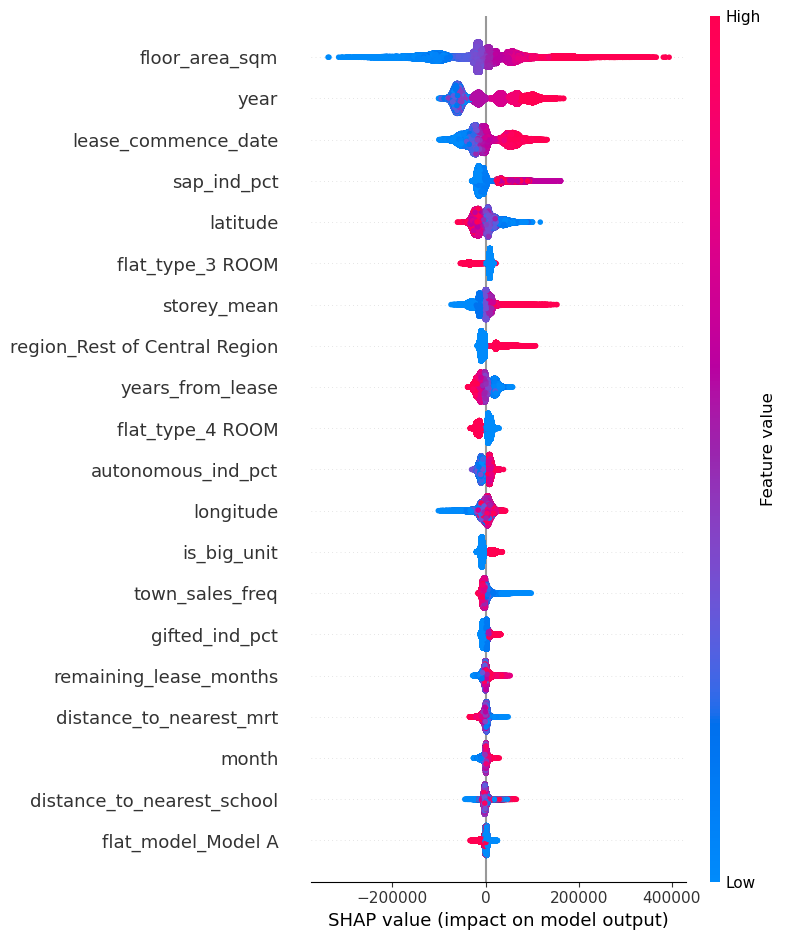

In [29]:
# Force reset index and ensure clean structure
X_shap_clean = X_shap.reset_index(drop=True).copy()

# Confirm that the entire DataFrame is convertible to float64
X_shap_clean = X_shap_clean.astype('float64')

# Now run SHAP
explainer = shap.Explainer(final_xgb_model, X_shap_clean)
shap_values = explainer(X_shap_clean)
shap.summary_plot(shap_values, X_shap_clean)
